<a href="https://colab.research.google.com/github/sanketsans/Image-Matting-U-Net/blob/master/ImageMatting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tqdm import tqdm 
from PIL import Image
import pickle as pkl
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sanketthakur","key":"a97a4e8e6996eb92ad8d022e38a9aeb8"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [0]:
!kaggle datasets list -s 'Matting Human'

ref                                             title                                    size  lastUpdated          downloadCount  
----------------------------------------------  --------------------------------------  -----  -------------------  -------------  
laurentmih/aisegmentcom-matting-human-datasets  AISegment.com - Matting Human Datasets   29GB  2019-06-06 18:35:59           2270  
vbookshelf/art-by-ai-neural-style-transfer      Art by Ai - Neural Style Transfer       463MB  2019-06-25 02:05:27             91  
4quant/interactivesegmentation                  InteractiveSegmentation                  17MB  2018-01-10 13:55:35            235  


In [0]:
!kaggle datasets download 'laurentmih/aisegmentcom-matting-human-datasets' -p /content/gdrive/My\ Drive/HumanMattingDatasets/

100% 28.8G/28.8G [09:15<00:00, 86.5MB/s]
100% 28.8G/28.8G [09:15<00:00, 55.6MB/s]


### To unzip the datasets

In [0]:
# import os
# import matplotlib.pyplot as plt
# from PIL import Image
# import cv2
# os.chdir('/content/gdrive/My Drive/HumanMattingDatasets/')
# for file in os.listdir(os.getcwd()):
#   # print(file)
#   os.system('unzip ' + file)

### To check the number of images in each folder

In [0]:
# start_id = '00000000'
# end_id = '00000010'

feat_img_dir = '/content/gdrive/My Drive/HumanMattingDatasets/matting/1803151818/matting_000000'
i = 0
for x in range(11):
  folder_num = str(x).zfill(2)
  folder = feat_img_dir + folder_num + '/'
  j = 0
  for file in os.listdir(folder):
    j += 1
  # print(j)
  i += j

print('total', i)


total 4813


## Creating an Image dataset for feature Image & target Image

In [0]:
class ImageDatasets(Dataset):
  def __init__(self, transform=None, root='/content/gdrive/My Drive/HumanMattingDatasets/', device=None):
    self.root = root
    self.feat_img_path = self.root + 'clip_img/1803151818/'
    self.target_img_path = self.root + 'matting/1803151818/'
    self.transform = transform
    self.device = device 
    self.ft_imgs = self.load_images(self.feat_img_path)
    self.tar_imgs = self.load_images(self.target_img_path)

  def __len__(self):
    if (len(self.ft_imgs) == len(self.tar_imgs)):
      return len(self.ft_imgs)

    else:
      return 0

  def __getitem__(self, index):
    ft = self.ft_imgs[index]
    tar = self.tar_imgs[index]

    feat_img = Image.open(ft)
    target_img = Image.open(tar)

    if self.transform:
      feat_img = self.transform(feat_img)
      target_img = self.transform(target_img)

    return feat_img, target_img

  def load_images(self, path):
    img_path = []
    fid = 0
    for folder in sorted(os.listdir(path)):
      fid = folder.split('_')[1]
      if(int(fid) > 20):
        break
      for file in sorted(os.listdir(path + folder)):
        img_path.append(path + folder + '/' + file)

    return img_path

In [0]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])

In [5]:
dataset = ImageDatasets(transform)
f, t = dataset[5]

print(f.shape, t.shape, len(dataset))

torch.Size([3, 128, 128]) torch.Size([4, 128, 128]) 9215


In [0]:
# x = torch.cat([f, t])
# x.shape

torch.Size([7, 256, 256])

## Splitting the dataset for training, validation and test purposes

In [33]:
split = 0.8
dataset_size = len(dataset)
indices = list(range(dataset_size))
train_indices = indices[ : int(dataset_size*split)]
val_indices = indices[int(dataset_size*split) : dataset_size-int(dataset_size*0.1)]
test_indices = indices[dataset_size-int(dataset_size*0.1) :]

print(len(train_indices), len(val_indices), len(test_indices))

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

7372 922 921


## Creating dataloader

In [0]:
BATCH_SIZE = 8
trainLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
valLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)
testLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

In [8]:
a = iter(trainLoader)
f, t = next(a)
f.shape

torch.Size([8, 3, 128, 128])

## Checking our dataloader to produce correct pair of feature & target Images.


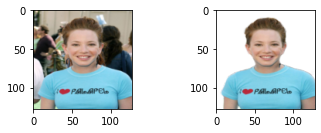

In [9]:
i1 = torchvision.transforms.ToPILImage()(f[5])
i2 = torchvision.transforms.ToPILImage()(t[5])
fig = plt.figure()
a1 = fig.add_subplot(221)
a1.imshow(i1)
a2 = fig.add_subplot(222)
a2.imshow(i2)

plt.show()

In [0]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-255.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [0]:
def conv(in_channel, out_channel, kernel_size=3, stride=1, padding=1, batchNorm=False):
  layers = []
  layers.append(nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias=False))
  if batchNorm:
    layers.append(nn.BatchNorm2d(out_channel))

  return nn.Sequential(*layers)

In [0]:
def deconv(in_channel, out_channel, kernel_size=4, stride=2, padding=1, batchNorm=False):
  layers = []
  layers.append(nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride, padding, bias=False))
  if batchNorm:
    layers.append(nn.BatchNorm2d(out_channel))

  return nn.Sequential(*layers)

In [0]:
def in_conv(in_channel, out_channel, batchNorm, kernel_size=3, stride=1, padding=1):
  conv1 = conv(in_channel, out_channel, kernel_size, stride, padding, batchNorm)
  conv2 = conv(out_channel, out_channel, kernel_size, stride, padding, batchNorm)

  layers = [conv1, conv2]

  return nn.Sequential(*layers)

In [0]:
def down_samp_conv(in_channel, out_channel, batchNorm, kernel_size=3, stride=1, padding=1):
  pool_layer = nn.MaxPool2d(2, 2)
  conv_layers = in_conv(in_channel, out_channel, batchNorm)

  layers = [pool_layer, conv_layers]
  return nn.Sequential(*layers)

In [0]:
def up_samp_conv(in_channel, out_channel, batchNorm, kernel_size=4, stride=2, padding=1):
  deconv_layer = deconv(in_channel, out_channel, kernel_size, stride, padding, batchNorm)

  return nn.Sequential(deconv_layer)

In [0]:
class Generator(nn.Module):
  def __init__(self, conv_dims=32):
    super(Generator, self).__init__()
    self.seed = 42
    ## input 3x128x128
    self.in_layer = in_conv(3, conv_dims, True) ## 32x128x128

    self.down_samp_conv1 = down_samp_conv(conv_dims, conv_dims*2, True) ## 64x64x64
    self.down_samp_conv2 = down_samp_conv(conv_dims*2, conv_dims*4, True) ## 128x32x32
    self.down_samp_conv3 = down_samp_conv(conv_dims*4, conv_dims*8, True) ## 256x16x16

    self.up_samp_conv1 = up_samp_conv(conv_dims*8, conv_dims*4, True)  ## 128x32x32
    self.up_concat_conv1 = in_conv(conv_dims*8, conv_dims*4, True)
    self.up_samp_conv2 = up_samp_conv(conv_dims*4, conv_dims*2, True) ## 64x64x64
    self.up_concat_conv2 = in_conv(conv_dims*4, conv_dims*2, True)
    self.up_samp_conv3 = up_samp_conv(conv_dims*2, conv_dims, True) ## 32x128x128
    self.up_concat_conv3 = in_conv(conv_dims*2, conv_dims, True)

    self.out_layer = nn.Sequential(*[conv(conv_dims, 4, batchNorm=True),
                                     conv(4, 4)])
    
    # in_conv(conv_dims, 4)

  def forward(self, x):
    ## Input size 3x128x128
    l1 = F.relu(self.in_layer(x)) ## 32x128x128
    d_l2 = F.relu(self.down_samp_conv1(l1)) ## 64x64x64
    d_l3 = F.relu(self.down_samp_conv2(d_l2)) ## 128x32x32
    d_l4 = F.relu(self.down_samp_conv3(d_l3)) ## 256x16x16

    up_l1 = F.relu(self.up_samp_conv1(d_l4)) ## 128x32x32
    up_l1_concat = torch.cat([up_l1, d_l3], dim=1) ## 256x32x32
    up_l1 = F.relu(self.up_concat_conv1(up_l1_concat))  ## 128x32x32

    up_l2 = F.relu(self.up_samp_conv2(up_l1)) ## 64x64x64
    up_l2_concat = torch.cat([up_l2, d_l2], dim=1) ## 128x64x64
    up_l2 = F.relu(self.up_concat_conv2(up_l2_concat))  ## 64x64x64

    up_l3 = F.relu(self.up_samp_conv3(up_l2)) ## 32x128x128
    up_l3_concat = torch.cat([up_l3, l1], dim=1) ## 64x128x128
    up_l3 = F.relu(self.up_concat_conv3(up_l3_concat))  ## 32x128x128

    out_layer = torch.tanh(self.out_layer(up_l3)) ## 4x128x128

    return out_layer


In [0]:
class Discriminator(nn.Module):
  def __init__(self, conv_dims=32):
    super(Discriminator, self).__init__()
    self.seed = 42
    self.conv1 = conv(4, conv_dims)
    self.conv2 = conv(conv_dims, conv_dims*2, batchNorm=True)
    self.conv3 = conv(conv_dims*2, conv_dims*4, batchNorm=True)
    self.conv4 = conv(conv_dims*4, conv_dims*8, batchNorm=True)
    self.conv5 = conv(conv_dims*8, conv_dims*16)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = F.leaky_relu(self.conv2(x), 0.2)
    x = F.leaky_relu(self.conv3(x), 0.2)
    x = F.leaky_relu(self.conv4(x), 0.2)
    x = self.conv5(x)

    return x

In [0]:
G, D = Generator(), Discriminator()
G = G.to(device)
# D = D.to(device)
# G.load_state_dict(torch.load('/content/gdrive/My Drive/HumanMattingDatasets/img_matting_checkpoint_G.pth'))

In [0]:
def view_results(epoch, fmg, index=1):
  fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=8, sharey=True, sharex=True)
  for ax, fimg in zip(axes.flatten(), fmg):
    # img = img.detach().cpu().numpy()
    # img = np.transpose(img, (1, 2, 0))
    # img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
    # # print(min(img), max(img))
    # ax.xaxis.set_visible(False)
    # ax.yaxis.set_visible(False)
    # im = ax.imshow(img.reshape((256,256,4)))

    fimg = fimg.detach().cpu().numpy()
    fimg = np.transpose(fimg, (1, 2, 0))
    fimg = ((fimg +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
    # print(min(img), max(img))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(fimg.reshape((128,128,3 + index)))

  plt.show()

## Results after partial training

## Actual Images

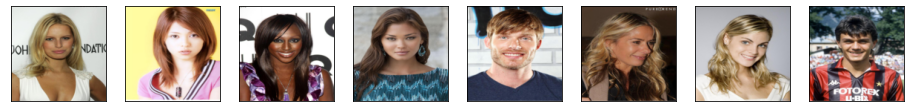

In [66]:
f, t = next(a)
f = f.to(device)
f = scale(f)
view_results(0, f, 0)

## Target Image vs partial training output

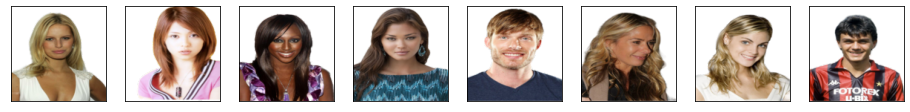

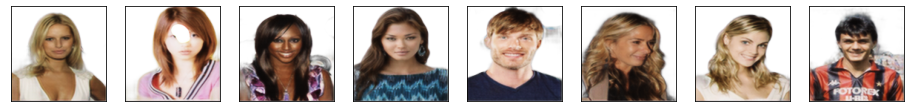

In [67]:
t = scale(t)
out = G(f)
view_results(0, t)
view_results(0, out)

In [0]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "false"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss

In [0]:
def view_samples(epoch, samples, index=1):
  fig, axes = plt.subplots(figsize=(16,4), nrows=1, ncols=8, sharey=True, sharex=True)
  for ax, fimg in zip(axes.flatten(), samples[epoch]):
    # img = img.detach().cpu().numpy()
    # img = np.transpose(img, (1, 2, 0))
    # img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
    # # print(min(img), max(img))
    # ax.xaxis.set_visible(False)
    # ax.yaxis.set_visible(False)
    # im = ax.imshow(img.reshape((256,256,4)))

    fimg = fimg.detach().cpu().numpy()
    fimg = np.transpose(fimg, (1, 2, 0))
    fimg = ((fimg +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
    # print(min(img), max(img))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(fimg.reshape((128,128,3 + index)))

  plt.show()

In [0]:
# hyperparams for Adam optimizers
lr= 0.0002
beta1= 0.5
beta2= 0.99
print_every = 10
losses = []
samples = []
act_samples = []

# Create optimizers for the generators and discriminators
criterion = nn.MSELoss(reduction='sum')
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])

In [0]:
def training_loop(trainLoader, valLoader, n_epochs=2000):
  min_loss = 10000.00
  val_iter = iter(valLoader)
  val_fixed_feat, val_fixed_tar = next(val_iter)
  val_fixed_feat = scale(val_fixed_feat)
  val_fixed_tar = scale(val_fixed_tar)
  val_fixed_feat = val_fixed_feat.to(device)
  val_fixed_tar = val_fixed_tar.to(device)

  act_samples.append(val_fixed_tar)

  iter_train_img = iter(trainLoader)
  batches_per_epochs = len(trainLoader)
  for epoch in (range(n_epochs)):
    # print('Epoch [{:5d}/{:5d}]'.format(epoch, n_epochs))
    if epoch % batches_per_epochs == 0:
      iter_train_img = iter(trainLoader)

    feat_img, tar_img = next(iter_train_img)

    feat_img = scale(feat_img)
    tar_img = scale(tar_img)

    feat_img = feat_img.to(device)
    tar_img = tar_img.to(device)

    # ## Discriminator
    # d_optimizer.zero_grad()
    # out_tar = D(tar_img)
    # fake_img = G(feat_img)
    # out_feat = D(fake_img)

    # d_loss_tar = real_mse_loss(out_tar)

    # d_loss_feat = fake_mse_loss(out_feat)

    # d_loss = d_loss_tar + d_loss_feat
    # d_loss.backward()
    # d_optimizer.step()

    ## Generator
    g_optimizer.zero_grad()
    fake_img = G(feat_img)
    # out_feat = D(fake_img)
    # g_loss_tar = real_mse_loss(out_feat)
    # reconstructed_loss = cycle_consistency_loss(tar_img, fake_img, lambda_weight=10)
    # g_loss = g_loss_tar
    g_loss = criterion(fake_img, tar_img)
    g_loss.backward()
    g_optimizer.step()

    # G.eval() # for generating samples
    # with torch.no_grad():
    #   samples_z = G(val_fixed_feat)
    #   samples.append(samples_z)
    #   view_samples(-1, samples)
    #   view_samples(-1, act_samples)
    # G.train() # back to training mode

    if epoch % print_every == 0:
      losses.append((g_loss.item()))
      print('Epoch [{:5d}/{:5d}] | g_total_loss: {:6.4f}'.format(
              epoch, n_epochs, g_loss.item()))
      # print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
      #         epoch, n_epochs, d_loss.item(), g_loss.item()))
      
    if g_loss.item() < min_loss :
      min_loss = g_loss.item()
      print('saving data ..  g_total_loss: {:6.4f} '.format(g_loss.item()))
      torch.save(G.state_dict(), '/content/gdrive/My Drive/HumanMattingDatasets/img_matting_checkpoint_G_2.pth')
      # torch.save(D.state_dict(), '/content/gdrive/My Drive/HumanMattingDatasets/img_matting_checkpoint_D.pth')

      # pkl_file = open('/content/gdrive/My Drive/HumanMattingDatasets/img_matting_train_samples.pkl', 'wb')
      # pkl.dump(samples, pkl_file)
      # pkl_file.close()


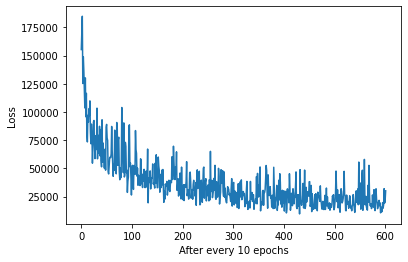

In [65]:
y = np.arange(len(losses))
plt.plot(y, losses)
plt.xlabel('After every 10 epochs')
plt.ylabel('Loss')
plt.show()

In [41]:
training_loop(trainLoader, valLoader)

Epoch [    0/ 1000] | g_total_loss: 155393.4688
saving data ..  g_total_loss: 155393.4688 
saving data ..  g_total_loss: 131017.4062 
saving data ..  g_total_loss: 115756.6094 
Epoch [   10/ 1000] | g_total_loss: 169386.9531
saving data ..  g_total_loss: 106088.1250 
Epoch [   20/ 1000] | g_total_loss: 184898.0312
saving data ..  g_total_loss: 105890.0078 
Epoch [   30/ 1000] | g_total_loss: 125256.7031
Epoch [   40/ 1000] | g_total_loss: 148978.5469
saving data ..  g_total_loss: 87429.3750 
Epoch [   50/ 1000] | g_total_loss: 136926.4844
Epoch [   60/ 1000] | g_total_loss: 121533.4531
Epoch [   70/ 1000] | g_total_loss: 103610.7500
saving data ..  g_total_loss: 86604.5000 
saving data ..  g_total_loss: 72830.1250 
Epoch [   80/ 1000] | g_total_loss: 130232.9688
Epoch [   90/ 1000] | g_total_loss: 95784.3359
Epoch [  100/ 1000] | g_total_loss: 116577.2422
saving data ..  g_total_loss: 70168.3906 
saving data ..  g_total_loss: 68810.6484 
Epoch [  110/ 1000] | g_total_loss: 80349.6719
E

In [0]:
pkl_file = open('/content/gdrive/My Drive/HumanMattingDatasets/img_matting_losses.pkl', 'wb')
pkl.dump(losses, pkl_file)
pkl_file.close()

In [64]:
training_loop(trainLoader, valLoader)

Epoch [    0/ 2000] | g_total_loss: 26891.4922
Epoch [   10/ 2000] | g_total_loss: 27235.1465
Epoch [   20/ 2000] | g_total_loss: 29756.5215
Epoch [   30/ 2000] | g_total_loss: 10535.9883
Epoch [   40/ 2000] | g_total_loss: 14226.0234
Epoch [   50/ 2000] | g_total_loss: 31869.4492
Epoch [   60/ 2000] | g_total_loss: 25273.5820
Epoch [   70/ 2000] | g_total_loss: 28433.8262
Epoch [   80/ 2000] | g_total_loss: 19555.1523
Epoch [   90/ 2000] | g_total_loss: 45280.9492
Epoch [  100/ 2000] | g_total_loss: 32509.5723
Epoch [  110/ 2000] | g_total_loss: 12951.1904
Epoch [  120/ 2000] | g_total_loss: 19055.3184
Epoch [  130/ 2000] | g_total_loss: 27975.7969
Epoch [  140/ 2000] | g_total_loss: 18304.2227
Epoch [  150/ 2000] | g_total_loss: 16995.1523
Epoch [  160/ 2000] | g_total_loss: 31971.9902
Epoch [  170/ 2000] | g_total_loss: 27958.9668
Epoch [  180/ 2000] | g_total_loss: 18560.4590
Epoch [  190/ 2000] | g_total_loss: 24225.6914
Epoch [  200/ 2000] | g_total_loss: 24348.5840
Epoch [  210/